# Implémentez un modèle de scoring

## Résumé du projet


## Chargement des bibliothèques nécessaires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import seaborn as sns
import os
import shutil
import re
from zipfile import ZipFile
from os import listdir
from pathlib import Path
import glob

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
import time
from sklearn.model_selection import KFold,train_test_split,cross_val_score, GridSearchCV

from sklearn.metrics import roc_auc_score,roc_curve,f1_score
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_curve,recall_score

from sklearn.preprocessing import LabelEncoder

## Données

In [2]:
dir_data = Path('../../DATA/P7') 
dir_fig  = Path('../../FIGURE/P7')
work_dir=os.getcwd()
CHECK_FOLDER  = Path('../../DATA/P7') 

csv_files = glob.glob(os.path.join(dir_data, '*.csv'))

if len(csv_files) > 0:
    print ("Fichier existe") 
else:
    for dirname, _, filenames in os.walk(dir_data):
        for filename in filenames:
            file_in=os.path.join(dirname, filename)
            print(file_in)
            with ZipFile(file_in, 'r') as zip:
                zip.extractall(dir_data)
    
    csv_files = glob.glob(os.path.join(dir_data, '*.csv'))
#


Fichier existe


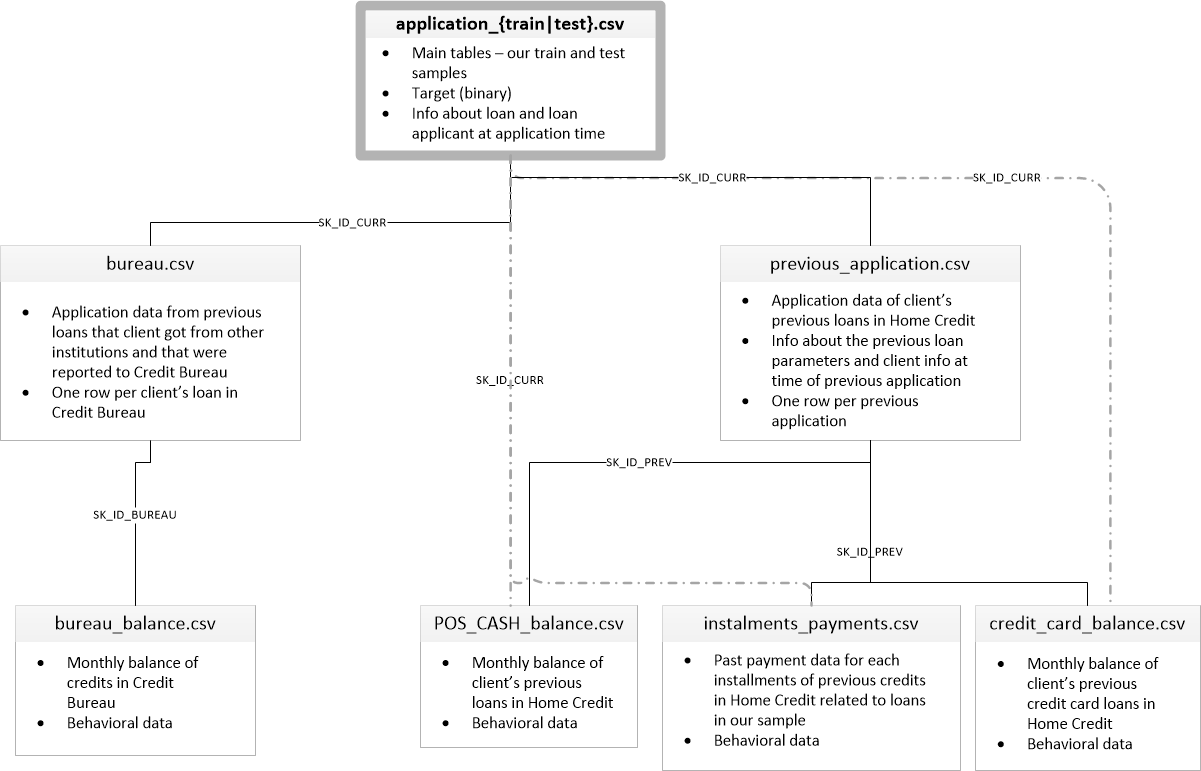

In [3]:
from IPython.display import Image
Image(filename = (Path(str(dir_fig) + "/home_credit.png")), width=1000, height=800)

In [5]:
data = {}
for file  in  csv_files:
    keys = file.split('../../DATA/P7/')[1].split('.csv')[0]
    data[keys] =pd.read_csv(file, encoding = "ISO-8859-1")
    display(f"{keys}: {data[keys].shape}")

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


'installments_payments: (13605401, 8)'

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%


'POS_CASH_balance: (10001358, 8)'

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


'application_test: (48744, 121)'

Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 14.8%


'HomeCredit_columns_description: (219, 5)'

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%


'credit_card_balance: (3840312, 23)'

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


'application_train: (307511, 122)'

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


'bureau_balance: (27299925, 3)'

Memory usage of dataframe is 0.74 MB
Memory usage after optimization is: 0.28 MB
Decreased by 62.5%


'sample_submission: (48744, 2)'

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


'bureau: (1716428, 17)'

KeyboardInterrupt: 

In [ ]:
for knx in data:
    if knx=='HomeCredit_columns_description':
        data[knx]=data[knx].drop(['Unnamed: 0'],axis=1)

Les differents fichiers ont des tailles differentes.

In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    df_missing_data=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return df_missing_data

valeur_manquante = pd.DataFrame()
for knx in data:
    print(knx)
    miss_val=missing_data(data[knx])
    valeur_manquante = pd.concat([valeur_manquante,
                            miss_val['Percent'].to_frame(name=knx)],
                            axis=1)
    

In [ ]:
valeur_manquante_pct = valeur_manquante.T.stack().reset_index()
valeur_manquante_pct.columns = ['Tableaux de données', 'column', '%données']
valeur_manquante_pct.sample(3)

In [ ]:
sns.stripplot(x='Tableaux de données', y='%données', data=valeur_manquante_pct,
              linewidth=1, alpha = 0.5, size=7)
plt.gcf().set_size_inches(10,5)
plt.xticks(rotation=90, ha='right')
ax = plt.gca()
ax.set_ylabel('Ratio de valeur manquante (%)')
ax.set_xlabel('Tableaux de données')
ax.set_title('Ratio des valeurs manquantes dans les colonnes de chaque tableau de données',
             fontweight='bold', pad=15)
plt.grid()


## Feature Engineering

In [ ]:
def data_missing_values_plot(df,table,yy,rot,ax,yleg,xleg,ftitle):
    # plot_tables missing values %
    df_missv=missing_data(df[table])
    xx=df_missv.index
    sns.lineplot(x=xx, y=yy, data=df_missv,linewidth=2,ax=ax)
    if rot==1:
        plt.xticks(rotation=90, ha='right')
    ax.set_ylabel(yleg,fontsize=18)
    ax.yaxis.set_label_coords(-0.05,1.05)
    ax.set_xlabel(xleg,fontsize=18)
    ax.set_title(ftitle,fontsize=18,fontweight='bold', pad=15)
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=12)
    plt.grid()

def remove_missing_val(df,table,threshold,data2use):
    cols_remove = df[table].columns[df[table].isnull().sum()/df[table].isnull().count()*100 >= threshold]
    data2use[table]= df[table].drop(cols_remove,axis=1)
    return data2use

def fill_remain_missing_val(data2use,table):
    for tnx in data2use[table].columns:
        tofill= data2use[table][tnx].median()
        data2use[table][tnx] = data2use[table][tnx].fillna(tofill)
    return data2use

def convert_categorical2numeric(data2use,table):
    for col in list(data2use[table].columns):
        if data2use[table][col].dtype == 'object':
            label_encoders = LabelEncoder()
            data2use[table][col]=label_encoders.fit_transform(data2use[table][col])
    return data2use


#### Train

In [ ]:
table='application_train'
# Remove vars that has too many missing variable
threshold=50  # 50 % of missing values
data2use={}   # values to use in the project
data2use=remove_missing_val(data,table,threshold,data2use)

In [ ]:
rotate_x_lab=1 # 1 yes
ylabel='Ratio de valeur manquante (%)'
xlabel='Variables'
ftitle='Ratio des valeurs manquantes dans les données application_train'

f, (ax1,ax2) = plt.subplots(2,1, figsize=(30,8),sharex=True,sharey=True)

data_missing_values_plot(data,table,'Percent',rotate_x_lab,ax1,'','',ftitle)
data_missing_values_plot(data2use,table,'Percent',rotate_x_lab,ax2,ylabel,xlabel,'')

In [ ]:
# convert categorical variables into numeric
data2use=convert_categorical2numeric(data2use,table)

In [ ]:
# data_merged_train2use = data_merged_train2use.fillna(-999) or with mean, median,....
data2use=fill_remain_missing_val(data2use,table)

#### Test

In [ ]:
table='application_test'
# Remove vars that has too many missing variable
data2use=remove_missing_val(data,table,threshold,data2use)

In [ ]:
rotate_x_lab=1 # 1 yes
ylabel='Ratio de valeur manquante (%)'
xlabel='Variables'
ftitle='Ratio des valeurs manquantes dans les données application_test'

f, (ax1,ax2) = plt.subplots(2,1, figsize=(30,8),sharex=True,sharey=True)

data_missing_values_plot(data,table,'Percent',rotate_x_lab,ax1,'','',ftitle)
data_missing_values_plot(data2use,table,'Percent',rotate_x_lab,ax2,ylabel,xlabel,'')

In [ ]:
# convert categorical variables into numeric
data2use=convert_categorical2numeric(data2use,table)

In [ ]:
# data_merged_train2use = data_merged_train2use.fillna(-999) or with mean, median,....
data2use=fill_remain_missing_val(data2use,table)

### credit_card_balance

In [ ]:
# Remove vars that has too many missing variable
table='credit_card_balance'
data2use=remove_missing_val(data,table,threshold,data2use)

In [ ]:
ftitle='Ratio des valeurs manquantes dans les données credit_card_balance'

f, (ax1,ax2) = plt.subplots(2,1, figsize=(30,8),sharex=True,sharey=True)

data_missing_values_plot(data,table,'Percent',rotate_x_lab,ax1,'','',ftitle)
data_missing_values_plot(data2use,table,'Percent',rotate_x_lab,ax2,ylabel,xlabel,'')

In [ ]:
# convert categorical variables into numeric
data2use=convert_categorical2numeric(data2use,table)

In [ ]:
# data_merged_train2use = data_merged_train2use.fillna(-999) or with mean, median,....
data2use=fill_remain_missing_val(data2use,table)

In [ ]:
# aggregate clients in unique id to match train/test set
aggr={'MONTHS_BALANCE':np.mean,
         'AMT_BALANCE':np.mean,
         'AMT_CREDIT_LIMIT_ACTUAL':np.mean,
         'AMT_DRAWINGS_ATM_CURRENT':np.mean,
         'AMT_DRAWINGS_CURRENT':np.mean,
         'AMT_DRAWINGS_OTHER_CURRENT':np.mean,
         'AMT_DRAWINGS_POS_CURRENT':np.mean,
         'AMT_INST_MIN_REGULARITY':np.mean,
         'AMT_PAYMENT_CURRENT':np.mean,
         'AMT_PAYMENT_TOTAL_CURRENT':np.mean,
         'AMT_RECEIVABLE_PRINCIPAL':np.mean,
         'AMT_RECIVABLE':np.mean,
         'AMT_TOTAL_RECEIVABLE':np.mean,
         'CNT_DRAWINGS_ATM_CURRENT':np.mean,
         'CNT_DRAWINGS_CURRENT':np.mean,
         'CNT_DRAWINGS_OTHER_CURRENT':np.mean,
         'CNT_DRAWINGS_POS_CURRENT':np.mean,
         'CNT_INSTALMENT_MATURE_CUM':np.mean,
         'NAME_CONTRACT_STATUS':np.mean,
         'SK_DPD':np.mean,
         'SK_DPD_DEF':np.mean}

data2use[table] = data2use[table].groupby(['SK_ID_CURR'],as_index=False).agg(aggr)

### previous_application

In [ ]:
table='previous_application'
data2use=remove_missing_val(data,table,threshold,data2use)

In [ ]:
ftitle='Ratio des valeurs manquantes dans les données previous_application'

f, (ax1,ax2) = plt.subplots(2,1, figsize=(30,8),sharex=True,sharey=True)

data_missing_values_plot(data,table,'Percent',rotate_x_lab,ax1,'','',ftitle)
data_missing_values_plot(data2use,table,'Percent',rotate_x_lab,ax2,ylabel,xlabel,'')

In [ ]:
# convert categorical variables into numeric
data2use=convert_categorical2numeric(data2use,table)

In [ ]:
# data_merged_train2use = data_merged_train2use.fillna(-999) or with mean, median,....
data2use=fill_remain_missing_val(data2use,table)

In [ ]:
# aggregate clients in unique id to match train/test set
aggr={
'NAME_CONTRACT_TYPE':np.mean, 'AMT_ANNUITY':np.mean,
'AMT_APPLICATION':np.mean, 'AMT_CREDIT':np.mean, 'AMT_GOODS_PRICE':np.mean,
'WEEKDAY_APPR_PROCESS_START':np.mean, 'HOUR_APPR_PROCESS_START':np.mean,
'FLAG_LAST_APPL_PER_CONTRACT':np.mean, 'NFLAG_LAST_APPL_IN_DAY':np.mean,
'NAME_CASH_LOAN_PURPOSE':np.mean, 'NAME_CONTRACT_STATUS':np.mean, 'DAYS_DECISION':np.mean,
'NAME_PAYMENT_TYPE':np.mean, 'CODE_REJECT_REASON':np.mean, 'NAME_TYPE_SUITE':np.mean,
'NAME_CLIENT_TYPE':np.mean, 'NAME_GOODS_CATEGORY':np.mean, 'NAME_PORTFOLIO':np.mean,
'NAME_PRODUCT_TYPE':np.mean, 'CHANNEL_TYPE':np.mean, 'SELLERPLACE_AREA':np.mean,
'NAME_SELLER_INDUSTRY':np.mean, 'CNT_PAYMENT':np.mean, 'NAME_YIELD_GROUP':np.mean,
'PRODUCT_COMBINATION':np.mean, 'DAYS_FIRST_DRAWING':np.mean, 'DAYS_FIRST_DUE':np.mean,
'DAYS_LAST_DUE_1ST_VERSION':np.mean, 'DAYS_LAST_DUE':np.mean, 'DAYS_TERMINATION':np.mean,
'NFLAG_INSURED_ON_APPROVAL':np.mean,  
}

data2use[table] = data2use[table].groupby(['SK_ID_CURR'],as_index=False).agg(aggr)

### installments_payments

In [ ]:
table='installments_payments'
data2use=remove_missing_val(data,table,threshold,data2use)

In [ ]:
ftitle='Ratio des valeurs manquantes dans les données installments_payments'

f, (ax1,ax2) = plt.subplots(2,1, figsize=(30,8),sharex=True,sharey=True)

data_missing_values_plot(data,table,'Percent',rotate_x_lab,ax1,'','',ftitle)
data_missing_values_plot(data2use,table,'Percent',rotate_x_lab,ax2,ylabel,xlabel,'')

In [ ]:
# convert categorical variables into numeric
data2use=convert_categorical2numeric(data2use,table)

In [ ]:
# data_merged_train2use = data_merged_train2use.fillna(-999) or with mean, median,....
data2use=fill_remain_missing_val(data2use,table)

In [ ]:
# aggregate clients in unique id to match train/test set
aggr={
'NUM_INSTALMENT_VERSION':np.mean,
       'NUM_INSTALMENT_NUMBER':np.mean, 'DAYS_INSTALMENT':np.mean, 'DAYS_ENTRY_PAYMENT':np.mean,
       'AMT_INSTALMENT':np.mean, 'AMT_PAYMENT':np.mean,  
}

data2use[table] = data2use[table].groupby(['SK_ID_CURR'],as_index=False).agg(aggr)

### POS_CASH_balance

In [ ]:
table='POS_CASH_balance'
data2use=remove_missing_val(data,table,threshold,data2use)

In [ ]:
ftitle='Ratio des valeurs manquantes dans les données bureau'

f, (ax1,ax2) = plt.subplots(2,1, figsize=(30,8),sharex=True,sharey=True)

data_missing_values_plot(data,table,'Percent',rotate_x_lab,ax1,'','',ftitle)
data_missing_values_plot(data2use,table,'Percent',rotate_x_lab,ax2,ylabel,xlabel,'')

In [ ]:
# convert categorical variables into numeric
data2use=convert_categorical2numeric(data2use,table)

In [ ]:
# data_merged_train2use = data_merged_train2use.fillna(-999) or with mean, median,....
data2use=fill_remain_missing_val(data2use,table)

In [ ]:
# aggregate clients in unique id to match train/test set
aggr={
    'MONTHS_BALANCE':np.mean, 
    'CNT_INSTALMENT':np.mean,
    'CNT_INSTALMENT_FUTURE':np.mean, 
    'NAME_CONTRACT_STATUS':np.mean, 
    'SK_DPD':np.mean,
    'SK_DPD_DEF':np.mean,  
}

data2use[table] = data2use[table].groupby(['SK_ID_CURR'],as_index=False).agg(aggr)

### sample_submission
This is target for test

In [ ]:
table='sample_submission'
data2use=remove_missing_val(data,table,threshold,data2use)

In [ ]:
# data_merged_train2use = data_merged_train2use.fillna(-999) or with mean, median,....
data2use=fill_remain_missing_val(data2use,table)

In [ ]:
ftitle='Ratio des valeurs manquantes dans les données sample_submission'

f, (ax1,ax2) = plt.subplots(2,1, figsize=(30,8),sharex=True,sharey=True)

data_missing_values_plot(data,table,'Percent',rotate_x_lab,ax1,'','',ftitle)
data_missing_values_plot(data2use,table,'Percent',rotate_x_lab,ax2,ylabel,xlabel,'')

### bureau + bureau_balance

In [ ]:
table='bureau'
data2use=remove_missing_val(data,table,threshold,data2use)

In [ ]:
ftitle='Ratio des valeurs manquantes dans les données bureau'

f, (ax1,ax2) = plt.subplots(2,1, figsize=(30,8),sharex=True,sharey=True)

data_missing_values_plot(data,table,'Percent',rotate_x_lab,ax1,'','',ftitle)
data_missing_values_plot(data2use,table,'Percent',rotate_x_lab,ax2,ylabel,xlabel,'')

In [ ]:
# convert categorical variables into numeric
data2use=convert_categorical2numeric(data2use,table)

In [ ]:
# data_merged_train2use = data_merged_train2use.fillna(-999) or with mean, median,....
data2use=fill_remain_missing_val(data2use,table)

### bureau_balance

In [ ]:
table='bureau_balance'
data2use=remove_missing_val(data,table,threshold,data2use)

In [ ]:
ftitle='Ratio des valeurs manquantes dans les données bureau_balance'

f, (ax1,ax2) = plt.subplots(2,1, figsize=(30,8),sharex=True,sharey=True)

data_missing_values_plot(data,table,'Percent',rotate_x_lab,ax1,'','',ftitle)
data_missing_values_plot(data2use,table,'Percent',rotate_x_lab,ax2,ylabel,xlabel,'')

In [ ]:
# convert categorical variables into numeric
data2use=convert_categorical2numeric(data2use,table)

In [ ]:
# data_merged_train2use = data_merged_train2use.fillna(-999) or with mean, median,....
data2use=fill_remain_missing_val(data2use,table)

In [ ]:
# merge bureau and bureau_balance as bureau balance does not have SK_ID_CURR
data2use['bureau']= data2use['bureau'].merge(data2use['bureau_balance'],on='SK_ID_BUREAU',how='left')
del data2use['bureau_balance']

In [ ]:
# aggregate clients in unique id to match train/test set
table='bureau'
aggr={
    'CREDIT_ACTIVE':np.mean, 
    'CREDIT_CURRENCY':np.mean,
    'DAYS_CREDIT':np.mean, 
    'CREDIT_DAY_OVERDUE':np.mean, 
    'DAYS_CREDIT_ENDDATE':np.mean,
    'DAYS_ENDDATE_FACT':np.mean, 
    #'AMT_CREDIT_MAX_OVERDUE':np.mean, 
    'CNT_CREDIT_PROLONG':np.mean,
    'AMT_CREDIT_SUM':np.mean, 
    'AMT_CREDIT_SUM_DEBT':np.mean, 
    'AMT_CREDIT_SUM_LIMIT':np.mean,
    'AMT_CREDIT_SUM_OVERDUE':np.mean, 
    'CREDIT_TYPE':np.mean, 
    'DAYS_CREDIT_UPDATE':np.mean,
    #'AMT_ANNUITY':np.mean, 
    'MONTHS_BALANCE':np.mean, 
    'STATUS':np.mean,  
}

data2use[table] = data2use[table].groupby(['SK_ID_CURR'],as_index=False).agg(aggr)

### Merge all in train set

In [ ]:
# Merge Credit tables into one
data_merged_train = data2use['application_train'].merge(data2use['credit_card_balance'],on='SK_ID_CURR',how='left')
data_merged_train = data_merged_train.merge(data2use['previous_application'],on='SK_ID_CURR',how='left')
data_merged_train = data_merged_train.merge(data2use['installments_payments'],on='SK_ID_CURR',how='left')
data_merged_train = data_merged_train.merge(data2use['POS_CASH_balance'],on='SK_ID_CURR',how='left')
data_merged_train = data_merged_train.merge(data2use['bureau'],on='SK_ID_CURR',how='left')
print(data2use['application_train'].shape,data_merged_train.shape)

### Merge all in test set

In [ ]:
# Merge Credit tables into one
data_merged_test = data2use['application_test'].merge(data2use['sample_submission'],on='SK_ID_CURR',how='left')
data_merged_test = data_merged_test.merge(data2use['credit_card_balance'],on='SK_ID_CURR',how='left')
data_merged_test = data_merged_test.merge(data2use['previous_application'],on='SK_ID_CURR',how='left')
data_merged_test = data_merged_test.merge(data2use['installments_payments'],on='SK_ID_CURR',how='left')
data_merged_test = data_merged_test.merge(data2use['POS_CASH_balance'],on='SK_ID_CURR',how='left')
data_merged_test = data_merged_test.merge(data2use['bureau'],on='SK_ID_CURR',how='left')
print(data2use['application_test'].shape,data_merged_test.shape)

## Data insights

### Train/Test

In [ ]:
f, axe = plt.subplots(2,3, figsize=(20,6),sharey=True)

sns.countplot(data=data_merged_train, x='TARGET',ax=axe[0,0])
sns.countplot(data=data_merged_train, x='CODE_GENDER',ax=axe[0,1]).set_title('Train')
sns.countplot(data=data_merged_train, x='NAME_FAMILY_STATUS',ax=axe[0,2])

f.subplots_adjust(left=0.1,bottom=0.1, right=1.1, top=0.9, wspace=0.4, hspace=0.4)
sns.countplot(data=data_merged_test, x='TARGET',ax=axe[1,0])
sns.countplot(data=data_merged_test, x='CODE_GENDER',ax=axe[1,1]).set_title('Test')
sns.countplot(data=data_merged_test, x='NAME_FAMILY_STATUS',ax=axe[1,2])

In [ ]:
f, axe= plt.subplots(2,3, figsize=(20,6))

sns.countplot(data=data_merged_train, x='OCCUPATION_TYPE',ax=axe[0,0])
sns.countplot(data=data_merged_train, x='NAME_EDUCATION_TYPE',ax=axe[0,1]).set_title('Train')
sns.countplot(data=data_merged_train, x='NAME_INCOME_TYPE',ax=axe[0,2])

f.subplots_adjust(left=0.1,bottom=0.1, right=1.1, top=0.9, wspace=0.4, hspace=0.4)
sns.countplot(data=data_merged_test, x='OCCUPATION_TYPE',ax=axe[1,0])
sns.countplot(data=data_merged_test, x='NAME_EDUCATION_TYPE',ax=axe[1,1]).set_title('Test')
sns.countplot(data=data_merged_test, x='NAME_INCOME_TYPE',ax=axe[1,2])

In [ ]:
f, axe = plt.subplots(2,3, figsize=(20,6))

sns.histplot(data=data_merged_train, x='ORGANIZATION_TYPE',ax=axe[0,0])
sns.histplot(data=data_merged_train[data_merged_train.CNT_DRAWINGS_CURRENT < 10], x='CNT_DRAWINGS_CURRENT',ax=axe[0,1]).set_title('Train')

sns.histplot(data=data_merged_train, x='DAYS_INSTALMENT',ax=axe[0,2])

f.subplots_adjust(left=0.1,bottom=0.1, right=1.1, top=0.9, wspace=0.4, hspace=0.4)
sns.histplot(data=data_merged_test, x='ORGANIZATION_TYPE',ax=axe[1,0])
sns.histplot(data=data_merged_test[data_merged_test.CNT_DRAWINGS_CURRENT < 10], x='CNT_DRAWINGS_CURRENT',ax=axe[1,1]).set_title('Test')
sns.histplot(data=data_merged_test, x='DAYS_INSTALMENT',ax=axe[1,2])


In [ ]:
coef_correl = data_merged_train.corr()

In [ ]:
# print  correlation of columns 

for thresh in [0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    li_corr_features = coef_correl[((np.abs(coef_correl)>thresh)&(np.abs(coef_correl)<1)).any(1)].index
    print('---threshold Pearson corr = '+str(thresh)+" -> {} columns".format(str(len(li_corr_features))))




In [ ]:
def plot_heatmap(corr, title, figsize=(8, 4), vmin=-1, vmax=1, center=0,
                 palette=sns.color_palette("coolwarm", 20), shape='rect',
                 fmt='.2f', annot=True, robust=False, fig=None, ax=None):

    fig = plt.figure(figsize=figsize) if fig is None else fig
    ax = fig.add_subplot(111) if ax is None else ax

    if shape == 'rect':
        mask = None
    elif shape == 'tri':
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None
        print('ERROR : this type of heatmap does not exist')

    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=annot, annot_kws={"size": 10}, fmt=fmt,
                     square=False, linewidths=.5, linecolor='white',
                     cbar_kws={"shrink": .9, 'label': None}, robust=robust,
                     xticklabels=corr.columns, yticklabels=corr.index,
                     ax=ax)
    ax.tick_params(labelsize=10, top=False, bottom=True,
                   labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=10)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=12)

In [ ]:
#### Select and vizualize high correlation features (>0.5)
corr_min=0.5
corr_max=1
high_correl_cols = coef_correl[((np.abs(coef_correl)>corr_min)&(np.abs(coef_correl)<corr_max)).any(1)].index
corr_high_corr = data_merged_train[high_correl_cols].corr()
plot_heatmap(corr_high_corr, 'Pearson correlation', shape='tri', annot=False, fmt='.2f',
             figsize=(25, 15), vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20))


In [ ]:
data_merged_train2use = data_merged_train[high_correl_cols ]
print(len(data_merged_train2use.columns))

In [ ]:
coef_correl = data_merged_train2use.corr()

columns = np.full((coef_correl.shape[0],), True, dtype=bool)
for i in range(coef_correl.shape[0]):
     for j in range(i+1, coef_correl.shape[0]):
        
        if abs(coef_correl.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
                        
selected_columns = data_merged_train2use.columns[columns]
data_merged_train2use= data_merged_train2use[selected_columns] 
print(selected_columns.shape)

In [ ]:
coef_correl=data_merged_train2use.corr()
plot_heatmap(coef_correl, 'Pearson correlation', shape='tri', annot=False, fmt='.2f',
             figsize=(25, 15), vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20))

In [ ]:
data_merged_train2use['TARGET']=data_merged_train['TARGET']

### Prep for modelling

In [ ]:
X=data_merged_train2use.drop('TARGET',axis=1)
Y=data_merged_train2use['TARGET']

In [ ]:

seed=42
scalar    = preprocessing.StandardScaler() 
std_scalar = scalar.fit(X) 
X_scaled  = std_scalar.transform(X)

In [ ]:
[X_train,X_test,Y_train,Y_test]=train_test_split(X_scaled,Y,test_size=0.3, random_state=seed)

## Modèlisation

In [ ]:
regressors = {
    "DummyClassifier":DummyClassifier(strategy="most_frequent"),
    "RandomForestClassifier": RandomForestClassifier(random_state=seed),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=seed),
    "XGBClassifier": XGBClassifier()
    }

params_regressors = {
    "DummyClassifier" :           {},
    "RandomForestClassifier":     {'bootstrap': [True, False],'max_depth': [10,30,50],'max_features': [2, 3],'min_samples_leaf': [3, 4, 5],
                                  'min_samples_split': [8, 10, 12],'n_estimators': [20,30,35] },
    "DecisionTreeClassifier":     {"splitter":["best","random"],"max_depth" : [1,5,10,15],"min_samples_leaf":[1,5,10],
                                  "min_weight_fraction_leaf":[0.1,0.5,1],
                                  "max_features":["auto","log2","sqrt",None],"max_leaf_nodes":[None,10,50,100] },
    "XGBClassifier":              {'learning_rate': [0.01, 0.1],'max_depth': [3, 5, 7, 10],'min_child_weight': [1, 3, 5],
                                  'subsample': [0.5, 0.7],'colsample_bytree': [0.5, 0.7],'n_estimators' : [100, 200, 500],
                                  'objective': ['reg:squarederror'] }   
    }

In [ ]:

def Multi_output_improved_regressor_model(regressors,params_regressors,X_train, y_train,X_test,y_test,n_splits,seed):
    
    results= pd.DataFrame(index=['F1','RECALL']) 
    
    Findex=['Cible predite']    
    frames_test= [] 
    column_regressor=[]
    
    for ks in regressors:
        column_regressor.append(ks)
#----------------------------------------------------------------y_EU

    for model_idx in regressors:
        
        start_time = time.time()
        #
        print(model_idx)
        model  = regressors[model_idx]
        #param_grid= params_regressors[model_idx]
        #kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        #dfs=kfold
        #cv_results = cross_val_score(regressor , X_train, y_train,cv=kfold)
    
        #grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=dfs)
        
        #grid_search.fit(X_train, y_train)
        
        #y_pred = grid_search.predict(X_test)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        f1_test = f1_score(y_test, y_pred)
        recall_test = recall_score(y_test, y_pred, average='weighted')
        print(f1_test,recall_test)
        results[model_idx]=[f1_test,recall_test ]

        y_pred=pd.DataFrame(y_pred,index=y_test.index,columns=Findex)
    
    
        Y_pred_test= pd.concat([y_test,y_pred],axis=1)
        frames_test.append(Y_pred_test)

    df_pred_train = pd.concat(frames_test, keys=column_regressor, axis=1)
    
    results=results.T
    
    results=results.sort_values(by=["RMSE"],axis=0, ascending=True)
    return results,df_pred_test


In [ ]:
nsplits=20
[eval_results_improved,pred_train_improved]=Multi_output_improved_regressor_model\
             (regressors,params_regressors,X_train,Y_train,X_test,Y_test,nsplits,seed)

In [ ]:
# label encoding every categorical features 
data_inter=copy.deepcopy(data[table])

for col in list(data[table].columns):
    if data[table][col].dtype == 'object':
        label_encoders = LabelEncoder()
        data_inter[col]=label_encoders.fit_transform(data[table][col])
        print(col)

We keep all variables. There is no need to drop any

In [ ]:
aggr={'MONTHS_BALANCE':np.mean,
         'AMT_BALANCE':np.mean,
         'AMT_CREDIT_LIMIT_ACTUAL':np.mean,
         'AMT_DRAWINGS_ATM_CURRENT':np.mean,
         'AMT_DRAWINGS_CURRENT':np.mean,
         'AMT_DRAWINGS_OTHER_CURRENT':np.mean,
         'AMT_DRAWINGS_POS_CURRENT':np.mean,
         'AMT_INST_MIN_REGULARITY':np.mean,
         'AMT_PAYMENT_CURRENT':np.mean,
         'AMT_PAYMENT_TOTAL_CURRENT':np.mean,
         'AMT_RECEIVABLE_PRINCIPAL':np.mean,
         'AMT_RECIVABLE':np.mean,
         'AMT_TOTAL_RECEIVABLE':np.mean,
         'CNT_DRAWINGS_ATM_CURRENT':np.mean,
         'CNT_DRAWINGS_CURRENT':np.mean,
         'CNT_DRAWINGS_OTHER_CURRENT':np.mean,
         'CNT_DRAWINGS_POS_CURRENT':np.mean,
         'CNT_INSTALMENT_MATURE_CUM':np.mean,
         'NAME_CONTRACT_STATUS':np.mean,
         'SK_DPD':np.mean,
         'SK_DPD_DEF':np.mean}

data2use[table] = data_inter.groupby(['SK_ID_CURR'],as_index=False).agg(aggr)

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,6),sharey=True)

sns.countplot(data=data_merged_test, x='TARGET',ax=ax1)
sns.countplot(data=data_merged_train, x='CODE_GENDER',ax=ax2)
sns.countplot(data=data_merged_train, x='NAME_FAMILY_STATUS',ax=ax3)